In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython import display

In [2]:
def iterate_minibatches(inputs, batchsize, shuffle=True):
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt]

In [3]:
#data = np.load("../data/npy/ES1_R1.npy")

### Synth data

In [4]:
def create_clust(dim):
    center = np.random.random(dim)*np.random.randint(1,50)
    
    #cov_1 = np.random.random((dim,dim))
    #cov_1 += cov_1.T
    #while not all(np.linalg.eigvals(cov_1) > 0):
    #    cov_1 = np.random.random((dim,dim))
    #    cov_1 += cov_1.T
    
    cov_1 = np.diag(np.ones(dim))
    
    return np.random.multivariate_normal(center, cov_1 * 2, 1000)

In [5]:
clust_1 = create_clust(4)
clust_2 = create_clust(4)
clust_3 = create_clust(4)

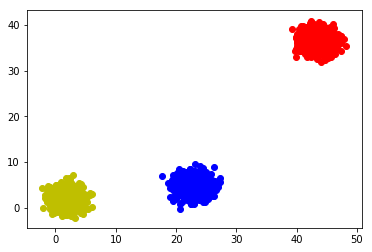

In [6]:
plt.scatter(clust_1[:,0],clust_1[:,1], c='y' )
plt.scatter(clust_2[:,0],clust_2[:,1], c='r' )
plt.scatter(clust_3[:,0],clust_3[:,1], c='b' )
plt.show()

In [7]:
data = np.concatenate((clust_1, clust_2, clust_3))

In [8]:
data

array([[  4.63083582,   1.88596975,  -1.59269187,   1.70061791],
       [ -0.6044543 ,   2.52569658,   0.96232162,  -0.22558999],
       [  4.71226555,   2.94104598,   1.4976849 ,  -0.92322529],
       ..., 
       [ 22.66782171,   5.18699783,  12.05795846,  13.84738617],
       [ 21.55906111,   5.31061734,  13.89121167,  14.42260578],
       [ 22.73053158,   3.29152718,  15.68422735,  14.74858679]])

In [15]:
# Training Parameters
learning_rate = 0.001
#num_steps = 30000
batch_size = 50
clusters_num = 3

#display_step = 1000
#examples_to_show = 10

# Network Parameters
num_hidden_1 = 100 # 1st layer num features
int_dim = 2 # 2nd layer num features (the latent dim)
num_input = 4 # MNIST data input (img shape: 28*28)

In [16]:
X = tf.placeholder("float", [None, num_input])

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([num_input, num_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([num_hidden_1, int_dim])),
    'decoder_h1': tf.Variable(tf.random_normal([int_dim, num_hidden_1])),
    'decoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_input])),
    'predictor_h_1': tf.Variable(tf.random_normal([int_dim + 1, num_hidden_1])),
    'predictor_h_2': tf.Variable(tf.random_normal([num_hidden_1, clusters_num]))
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([int_dim])),
    'decoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
    'decoder_b2': tf.Variable(tf.random_normal([num_input])),
    'predictor_b_1': tf.Variable(tf.random_normal([num_hidden_1])),
    'predictor_b_2': tf.Variable(tf.random_normal([clusters_num]))
}

# Building the encoder

    # Encoder Hidden layer with sigmoid activation #1
enc_layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(X, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Encoder Hidden layer with sigmoid activation #2
z = tf.nn.sigmoid(tf.add(tf.matmul(enc_layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))


# Building the decoder

    # Decoder Hidden layer with sigmoid activation #1
dec_layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(z, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
decoder = tf.add(tf.matmul(dec_layer_1, weights['decoder_h2']),
                                   biases['decoder_b2'])

In [17]:
mse = tf.reduce_mean(tf.squared_difference(decoder, X), 1)

predictor_inp = tf.concat([z, tf.reshape(mse, (-1,1))], axis = 1)

In [18]:
predictor_layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(predictor_inp, weights['predictor_h_1']),
                                   biases['predictor_b_1']))
gamma = tf.nn.softmax(tf.add(tf.matmul(predictor_layer_1, weights['predictor_h_2']),
                                   biases['predictor_b_2']))

In [19]:
def est_gmm(gamma, z):
    weights = tf.reduce_mean(gamma, reduction_indices=[0])
    means = tf.transpose(tf.matmul(tf.transpose(z), gamma) / tf.transpose(tf.reduce_sum(gamma, reduction_indices=[0])))
    
    z_minus_means = tf.map_fn(lambda x: z - x, means)

    def internal(x):
        x = tf.reshape(x, (1,-1))
        return tf.matmul(tf.transpose(x), x)

    matrixes = tf.map_fn(lambda x: tf.map_fn(internal, x), z_minus_means)
    
    m_r = tf.reshape(matrixes, (clusters_num * batch_size, int_dim * int_dim))
    m_r2 = tf.reshape(matrixes, (clusters_num * batch_size, int_dim * int_dim)) * tf.reshape(tf.transpose(gamma), (clusters_num * batch_size,1))
    m_r3 = tf.reduce_sum(tf.reshape(m_r2, (clusters_num,batch_size,int_dim,int_dim)), [1]) 
    sigmas = tf.reshape(tf.transpose(tf.transpose(tf.reshape(m_r3, (clusters_num, int_dim * int_dim))) / tf.reduce_sum(gamma, 0)), (clusters_num,int_dim,int_dim))
    
    means_minus_z = tf.map_fn(lambda x: means - x, z)
    
    def internal_e_1(z):
        #return (-0.5 * tf.map_fn(lambda x: tf.matmul(tf.matmul(tf.reshape(x, (1, -1)), z[1]), tf.reshape(x, (-1,1))), z[0]), 0.)
        #return tf.map_fn(lambda x,y: (tf.matmul(tf.reshape(x, (1, -1)), y), 0.), (z, sigmas), dtype=(tf.float32, tf.float32))[0]
        return tf.exp( -0.5 * 
            tf.map_fn(lambda x: tf.matmul(tf.matmul(tf.reshape(x, (1, -1)), tf.linalg.inv(z[1])),  tf.reshape(x, (-1, 1))),
                      z[0])) / tf.sqrt(tf.abs(tf.linalg.det(z[1])))

    #en_1 = tf.map_fn(lambda x: tf.transpose(x, (1,0,2)),means_minus_z)#, dtype=(tf.float32, tf.float32))
    en_1 = tf.transpose(means_minus_z, (1,0,2))

    en_2 = tf.map_fn(internal_e_1, (en_1, sigmas), dtype=(tf.float32))

    en = tf.reduce_mean(-tf.log(tf.reduce_sum(tf.transpose(tf.reshape(en_2, (clusters_num, batch_size))) * weights, 1)))
    
    return weights, means, sigmas, en

In [20]:
w, m, s, e = est_gmm(gamma, z)

In [21]:
# Define loss and optimizer, minimize the squared error
loss = tf.reduce_mean(mse)+ 0.01 * e + tf.reduce_sum(0.001 / s)
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [34]:
sess.close()

In [22]:
sess = tf.Session()
sess.run(init)

# Training

In [23]:
epochs = 30
losses = []

In [24]:
batch_size

50

In [35]:
sess.run([mse, z, gamma, s], feed_dict={X: data[1990:1990 + batch_size]})

[array([ 1183.78393555,  1262.59716797,  1416.48303223,  1368.10888672,
         1246.22045898,  1375.89465332,  1270.37670898,  1323.63049316,
         1353.40197754,  1309.61914062,   270.83230591,   253.5715332 ,
          266.6416626 ,   319.92532349,   299.41912842,   309.18899536,
          301.73791504,   305.04962158,   271.15463257,   325.20141602,
          277.45022583,   297.7142334 ,   268.99887085,   329.20132446,
          269.27923584,   275.41015625,   232.63874817,   239.3964386 ,
          294.01409912,   307.61743164,   326.44415283,   286.04260254,
          279.0723877 ,   265.73730469,   280.5635376 ,   275.3460083 ,
          284.77056885,   322.63656616,   304.51107788,   285.08877563,
          326.52084351,   305.32580566,   262.28399658,   257.8465271 ,
          303.18804932,   324.9548645 ,   256.67028809,   275.94665527,
          307.82559204,   288.51852417], dtype=float32),
 array([[  2.71827608e-01,   1.74954291e-02],
        [  5.95317543e-01,   5.96

In [39]:
s

<tf.Tensor 'Reshape_6:0' shape=(3, 2, 2) dtype=float32>

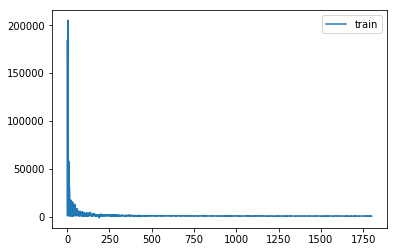

In [26]:
for i in range(epochs):
    for batch in iterate_minibatches(data, batch_size, shuffle = True):
        _, l = sess.run([optimizer, loss], feed_dict={X: batch})
        losses.append(l)
    # Display logs per step
    
    if i % 1 == 0 or i == 1:
        print('Step %i: Minibatch Loss: %f' % (i, l))
        
        display.clear_output(wait=True)
        plt.plot(losses, label='train')
    #    plt.plot(v_losses_valid, label='validation')
        plt.legend()
        plt.show()


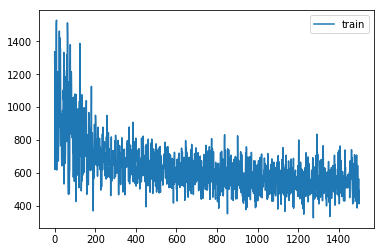

In [34]:
plt.plot(losses[300:], label='train')
#    plt.plot(v_losses_valid, label='validation')
plt.legend()
plt.show()

In [27]:
sess.run([z], {X: data[1990:2010]})

[array([[  2.71827608e-01,   1.74954291e-02],
        [  5.95317543e-01,   5.96183836e-02],
        [  6.49069071e-01,   7.18951598e-02],
        [  6.31421208e-01,   6.81611001e-02],
        [  2.39237294e-01,   1.26763489e-02],
        [  5.57572365e-01,   4.99365851e-02],
        [  3.59433532e-01,   2.08036192e-02],
        [  6.06484532e-01,   6.24979883e-02],
        [  6.42769277e-01,   6.84186071e-02],
        [  5.12120843e-01,   4.52152528e-02],
        [  1.14236704e-04,   3.47642999e-05],
        [  1.00403893e-04,   3.28869100e-05],
        [  1.43450277e-04,   3.03295874e-05],
        [  1.21497513e-04,   2.71637673e-05],
        [  1.26168510e-04,   3.21092448e-05],
        [  1.08892542e-04,   2.97743627e-05],
        [  2.03185045e-04,   2.69356806e-05],
        [  8.93990218e-05,   2.41637372e-05],
        [  1.34706032e-04,   2.97429215e-05],
        [  1.12432164e-04,   3.06944094e-05]], dtype=float32)]

In [28]:
sess.run([decoder], {X: data[1990:2010]}) 

[array([[-2.93809795,  2.16767669,  0.85736245, -3.89570618],
        [-3.54628396,  1.12131691, -0.63377976, -4.42456675],
        [-3.63428664,  0.96400797, -0.86993033, -4.52550507],
        [-3.60453463,  1.01561511, -0.79179281, -4.49368525],
        [-2.87793064,  2.27832794,  1.0021472 , -3.83721876],
        [-3.48756814,  1.23260677, -0.46999007, -4.34865427],
        [-3.12378001,  1.8653456 ,  0.44033203, -4.01592684],
        [-3.56364512,  1.08871615, -0.68211782, -4.44692135],
        [-3.6294322 ,  0.98013186, -0.84741563, -4.50610399],
        [-3.39876699,  1.37597096, -0.25550175, -4.28177881],
        [-2.37415361,  3.13269234,  2.06429815, -3.47714877],
        [-2.37412667,  3.13274217,  2.06435323, -3.47712398],
        [-2.37423086,  3.13258171,  2.0641613 , -3.47717333],
        [-2.37418771,  3.13265848,  2.06425047, -3.4771328 ],
        [-2.37418699,  3.13264775,  2.06423998, -3.47715616],
        [-2.37415385,  3.13270783,  2.06431174, -3.47712421],
        

In [29]:
data[1990:2010]

array([[ 40.63160119,  35.18768172,  41.69050189,   5.00097037],
       [ 42.32156451,  35.23758193,  41.02075037,   2.46817333],
       [ 42.93520667,  40.15466595,  43.01661294,   1.41404282],
       [ 43.60517578,  37.72592487,  42.29120681,   1.82197111],
       [ 44.03246801,  33.88542523,  42.54485442,   3.87586556],
       [ 45.23387908,  38.937554  ,  40.23768523,   2.79428361],
       [ 43.54996105,  36.24667679,  40.97884743,   4.79438018],
       [ 43.36753573,  37.94028198,  40.46121331,   1.96983576],
       [ 42.42861006,  38.13285136,  42.5575252 ,   0.78076408],
       [ 44.35253009,  38.66629322,  38.79877097,   2.23634388],
       [ 21.92621277,   3.59606784,  15.12397437,  14.46864711],
       [ 22.11061306,   2.2129232 ,  13.51818674,  13.33796751],
       [ 21.05518116,   5.22636356,  13.03503519,  16.34415934],
       [ 23.92919066,   4.98274096,  15.37061401,  16.7058172 ],
       [ 23.05809014,   4.72859808,  15.44903836,  15.73679385],
       [ 24.33550192,   5

In [10]:
summ_writer = tf.summary.FileWriter("/home/anton/TF_logs/CRISPR/", sess.graph, filename_suffix="AE")

In [37]:
summ_writer.close()

In [24]:
#gamma = tf.placeholder(tf.float32)
#z = tf.placeholder(tf.float32)    

weights = tf.reduce_mean(gamma, reduction_indices=[0])
means = tf.transpose(tf.matmul(tf.transpose(z), gamma) / tf.transpose(tf.reduce_sum(gamma, reduction_indices=[0])))

z_minus_means = tf.reshape(tf.map_fn(lambda x: z - x, means), [-1, int_dim])

z_minus_means_squared = tf.map_fn(lambda x: tf.reduce_sum(x * x), z_minus_means)

sigma_flat = tf.reduce_sum(tf.transpose(tf.reshape(
        z_minus_means_squared * tf.reshape(tf.transpose(gamma), (1, -1)), [clusters_num, batch_size])), 0) / tf.reduce_sum(gamma, 0)

pre_energy = tf.reduce_sum(tf.exp(-0.5 * tf.transpose(
    tf.reshape(z_minus_means_squared,  [clusters_num, batch_size])) / sigma_flat) * weights  / tf.sqrt(6.28  * sigma_flat),1 )
                           
energy = tf.reduce_mean(-tf.log(tf.reduce_sum(tf.exp(-0.5 * tf.transpose(
    tf.reshape(z_minus_means_squared,  [clusters_num, batch_size])) / sigma_flat) * weights  / tf.sqrt(6.28  * sigma_flat), 1)))